In [1]:
import h5py
from matplotlib.font_manager import findSystemFonts
from scipy.io import loadmat

def iterate_group(data: h5py.Group, final_data: dict):
    """
    Recursively iterate through a h5py Group and print its structure.
    """
    for key in data.keys():
        item = data[key]
        if isinstance(item, h5py.Group):
            final_data[key] = {}
            iterate_group(item, final_data[key])
        else:
            final_data[key] = item[:]
    return final_data

def load_data_matfile(path: str, name: list[str]=[]):
    with h5py.File(path, 'r') as f:
        # List all groups in the file
        # print("Keys in the file:", list(f.keys()))
        # Access the dataset
        
        if len(name) == 0:
            data = {}
            iterate_group(f, data)
            return data
        else:
            result = {}
            for key in name:
                if isinstance(f[key], h5py.Group):
                    # print("key is a group, iterating through it")
                    result[key] = iterate_group(f[key], {})
                else:
                    # print("key is a dataset, returning data")
                    data = f[key][:]
                    data = data.T  # Transpose to match MATLAB's column-major order
                    result[key] = data 
            return result

def load_result_matfile(path: str):
    data = loadmat(path)
    return data

In [2]:
import os
from collections import Counter, defaultdict
import numpy as np

# ---------- Config ----------
BASE_DIR = "../nvflare_code/test_output"        # root folder
ROUNDS = range(0, 5)            # i in 0..4
SITES = ['site1', 'site2']                  # j in 1..2
NPZ_NAME = "centers.npz"        # change if your file is named differently
KEYS = ("typ_sz", "typ_hc")     # keys to count
# ----------------------------

def count_values(arr) -> Counter:
    """
    Flatten array-like to 1-D and count values.
    Casts to Python scalars to make Counter happy.
    """
    if arr is None:
        return Counter()
    a = np.asarray(arr).ravel()
    # If the array is float but contains integers (e.g., 1.0, 2.0), you can
    # uncomment the next line to coerce to int:
    # a = a.astype(int)
    return Counter(map(lambda x: x.item() if hasattr(x, "item") else x, a))

# freq[site][key] -> Counter of values across all rounds
freq = {site: {k: Counter() for k in KEYS} for site in SITES}
feat_freq = {site: Counter() for site in SITES}

missing_files = []
missing_keys = defaultdict(lambda: defaultdict(int))  # missing_keys[site][key] count

for i in ROUNDS:
    for site in SITES:
        npz_path = os.path.join(BASE_DIR, f"round_{i}", site, NPZ_NAME)
        txt_path = os.path.join(BASE_DIR, f"round_{i}", site, "selected_features.txt")
        
        if not os.path.exists(npz_path):
            missing_files.append(npz_path)
            continue
        
        if not os.path.exists(txt_path):
            missing_files.append(txt_path)
            continue
        
        try:
            with np.load(npz_path, allow_pickle=True) as data:
                for k in KEYS:
                    if k not in data.files:
                        missing_keys[site][k] += 1
                        continue
                    cnt = count_values(data[k])
                    freq[site][k].update(cnt)
                    
            with open(txt_path, "r") as f:
                values = [int(line.strip()) for line in f if line.strip()]
                feat_freq[site].update(values)

        except Exception as e:
            print(f"[WARN] Failed to load {npz_path}: {e}")

# ---------- Results ----------
# Pretty-print frequencies per site
for site in SITES:
    print(f"\n=== Site {site} ===")
    for k in KEYS:
        
        # print(f"  {k} (value -> count):")
        # for val, c in freq[site][k].most_common():
        #     print(f"    {val}: {c}")
    
        total = len(freq[site][k])
        num_keys_with_freq_k = sum(1 for val, count in freq[site][k].items() if count == 5)
        percentage_keys = (num_keys_with_freq_k / total * 100) if total > 0 else 0
        
        print(f"Site {site}, Key '{k}':")
        print(f"Total entries = {total}")
        print(f"Total subjects appeared constantly = {num_keys_with_freq_k}")
        print(f"Percentage = {percentage_keys:.2f}%")
    
    num_keys_with_freq_k = sum(1 for val, count in feat_freq[site].items() if count == 5)
    total_keys = len(feat_freq[site])
    percentage_keys = (num_keys_with_freq_k / total_keys * 100) if total_keys > 0 else 0

    print(f"\n[Selected Features] Site {site}:")
    print(f"  #features with frequency {k} = {num_keys_with_freq_k}")
    print(f"  Percentage = {percentage_keys:.2f}%")



=== Site site1 ===
Site site1, Key 'typ_sz':
Total entries = 57
Total subjects appeared constantly = 53
Percentage = 92.98%
Site site1, Key 'typ_hc':
Total entries = 52
Total subjects appeared constantly = 47
Percentage = 90.38%

[Selected Features] Site site1:
  #features with frequency typ_hc = 179
  Percentage = 83.64%

=== Site site2 ===
Site site2, Key 'typ_sz':
Total entries = 101
Total subjects appeared constantly = 99
Percentage = 98.02%
Site site2, Key 'typ_hc':
Total entries = 97
Total subjects appeared constantly = 91
Percentage = 93.81%

[Selected Features] Site site2:
  #features with frequency typ_hc = 666
  Percentage = 96.10%


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distance_boxplots(res, site_name="Site"):
    """res = output dict from distances_to_center_typicals(...)"""
    # Euclidean
    dE_HC = res["euclid"]["HC"]; dE_SZ = res["euclid"]["SZ"]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.boxplot([dE_HC, dE_SZ], labels=["HC (typ)", "SZ (typ)"], showfliers=False)
    ax.set_title(f"{site_name} — Distance to class center (Euclidean)")
    ax.set_ylabel("Distance")
    ax.grid(True, axis="y", alpha=0.3)
    plt.show()

    # Mahalanobis (if present)
    dM_HC = res["mahal"]["HC"]; dM_SZ = res["mahal"]["SZ"]
    if dM_HC is not None and dM_SZ is not None:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.boxplot([dM_HC, dM_SZ], labels=["HC (typ)", "SZ (typ)"], showfliers=False)
        ax.set_title(f"{site_name} — Distance to class center (Mahalanobis)")
        ax.set_ylabel("Distance")
        ax.grid(True, axis="y", alpha=0.3)
        plt.show()

def _ecdf(x):
    x = np.asarray(x)
    xs = np.sort(x)
    ys = np.arange(1, x.size + 1) / x.size
    return xs, ys

def plot_distance_ecdfs(res, site_name="Site"):
    """ECDFs for Euclidean (and Mahalanobis if available)."""
    # Euclidean
    dE_HC = res["euclid"]["HC"]; dE_SZ = res["euclid"]["SZ"]
    x1,y1 = _ecdf(dE_HC); x2,y2 = _ecdf(dE_SZ)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(x1, y1, label="HC (typ)")
    ax.plot(x2, y2, label="SZ (typ)")
    ax.set_title(f"{site_name} — ECDF of distance to center (Euclidean)")
    ax.set_xlabel("Distance"); ax.set_ylabel("F(x)")
    ax.grid(True, alpha=0.3); ax.legend()
    plt.show()

    # Mahalanobis (if present)
    dM_HC = res["mahal"]["HC"]; dM_SZ = res["mahal"]["SZ"]
    if dM_HC is not None and dM_SZ is not None:
        x1,y1 = _ecdf(dM_HC); x2,y2 = _ecdf(dM_SZ)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(x1, y1, label="HC (typ)")
        ax.plot(x2, y2, label="SZ (typ)")
        ax.set_title(f"{site_name} — ECDF of distance to center (Mahalanobis)")
        ax.set_xlabel("Distance"); ax.set_ylabel("F(x)")
        ax.grid(True, alpha=0.3); ax.legend()
        plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import chi2

def plot_pca_ellipses_typicals(
    X,                 # (N, F) full features (no labels)
    feat_idx,          # indices of Bonferroni-selected features used to build centers
    typ_idx_HC,        # indices (or boolean mask) of typical HC in THIS site
    typ_idx_SZ,        # indices (or boolean mask) of typical SZ in THIS site
    center_HC=None,    # (F_sel,) optional: center vector for HC (to plot as star)
    center_SZ=None,    # (F_sel,) optional: center vector for SZ (to plot as star)
    site_name="Site"
):
    def _to_mask(n, idx_or_mask):
        arr = np.asarray(idx_or_mask)
        if arr.dtype == bool:
            return arr
        mask = np.zeros(n, dtype=bool); mask[arr.astype(int)] = True; return mask

    # 1) restrict to selected feature subspace
    Fsel = np.asarray(feat_idx, dtype=int)
    Xsel = X[:, Fsel]
    mask_HC = _to_mask(X.shape[0], typ_idx_HC)
    mask_SZ = _to_mask(X.shape[0], typ_idx_SZ)
    X_HC = Xsel[mask_HC]
    X_SZ = Xsel[mask_SZ]

    # 2) PCA on typicals (both classes together), to 2D
    X_typ = np.vstack([X_HC, X_SZ])
    pca = PCA(n_components=2, random_state=42).fit(X_typ)
    Z_HC = pca.transform(X_HC)
    Z_SZ = pca.transform(X_SZ)

    # 3) 95% covariance ellipses
    def ellipse_params(Z2):
        mu = Z2.mean(axis=0)
        C = np.cov(Z2, rowvar=False)
        vals, vecs = np.linalg.eigh(C); order = np.argsort(vals)[::-1]
        vals, vecs = vals[order], vecs[:, order]
        r = np.sqrt(vals * chi2.ppf(0.95, df=2))   # radii along eigenvectors
        theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
        area = float(np.pi * r[0] * r[1])         # ellipse area
        return mu, r, theta, area

    mu_HC, r_HC, th_HC, area_HC = ellipse_params(Z_HC)
    mu_SZ, r_SZ, th_SZ, area_SZ = ellipse_params(Z_SZ)

    # 4) plot
    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(Z_HC[:,0], Z_HC[:,1], s=18, alpha=0.55, label="HC (typ)")
    ax.scatter(Z_SZ[:,0], Z_SZ[:,1], s=18, alpha=0.55, label="SZ (typ)")

    def draw_ellipse(mu, r, theta, **kw):
        t = np.linspace(0, 2*np.pi, 400)
        R = np.array([[np.cos(np.radians(theta)), -np.sin(np.radians(theta))],
                      [np.sin(np.radians(theta)),  np.cos(np.radians(theta))]])
        pts = (R @ np.vstack([r[0]*np.cos(t), r[1]*np.sin(t)])).T + mu
        ax.plot(pts[:,0], pts[:,1], **kw)

    draw_ellipse(mu_HC, r_HC, th_HC, lw=2, label="HC 95% ellipse")
    draw_ellipse(mu_SZ, r_SZ, th_SZ, lw=2, label="SZ 95% ellipse")

    # (optional) project and plot centers as stars
    if center_HC is not None and center_SZ is not None:
        Cstar_HC = pca.transform(center_HC.reshape(1,-1))
        Cstar_SZ = pca.transform(center_SZ.reshape(1,-1))
        ax.scatter(Cstar_HC[0,0], Cstar_HC[0,1], marker="*", s=160, edgecolor="k", zorder=5, label="HC center")
        ax.scatter(Cstar_SZ[0,0], Cstar_SZ[0,1], marker="*", s=160, edgecolor="k", zorder=5, label="SZ center")

    var2 = pca.explained_variance_ratio_[:2].sum() * 100
    ax.set_title(f"{site_name} — PCA (2D) of typicals with 95% ellipses (var≈{var2:.1f}%)")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.legend(loc="best"); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    return {"HC_ellipse_area": area_HC, "SZ_ellipse_area": area_SZ, "pca_var_2d_pct": float(var2)}


157 52
inside Mask:  157 52
lenght of arr:  52
inside Mask:  157 56
lenght of arr:  56


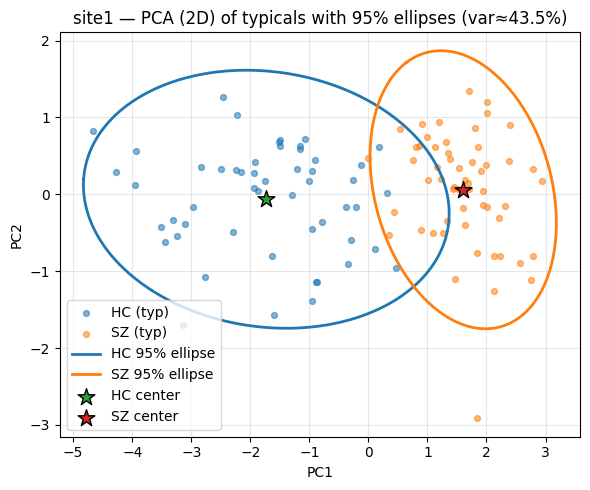

311 94
inside Mask:  311 94
lenght of arr:  94
inside Mask:  311 100
lenght of arr:  100


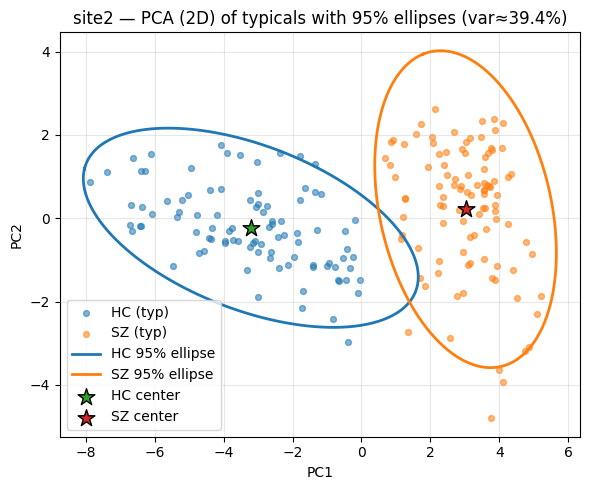

157 51
inside Mask:  157 51
lenght of arr:  51
inside Mask:  157 55
lenght of arr:  55


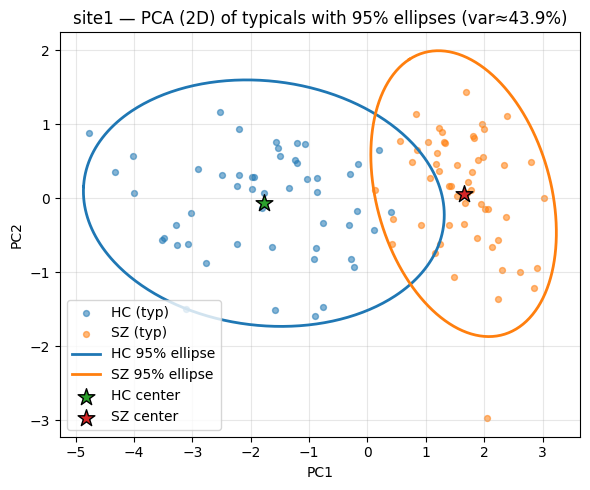

311 94
inside Mask:  311 94
lenght of arr:  94
inside Mask:  311 101
lenght of arr:  101


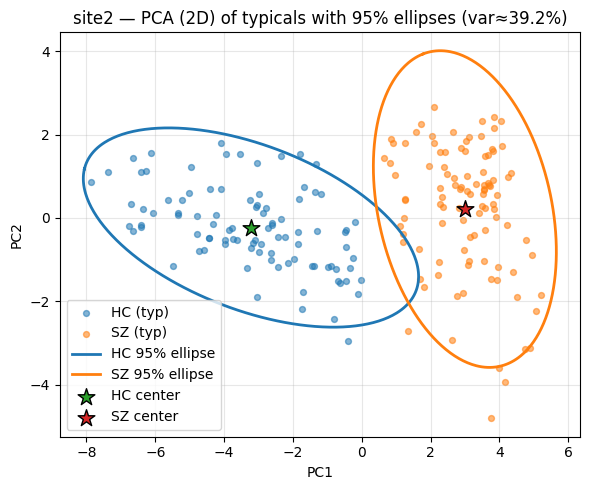

157 50
inside Mask:  157 50
lenght of arr:  50
inside Mask:  157 56
lenght of arr:  56


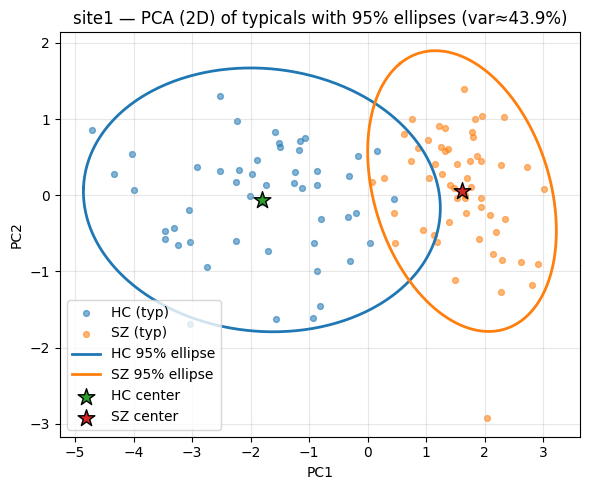

311 94
inside Mask:  311 94
lenght of arr:  94
inside Mask:  311 101
lenght of arr:  101


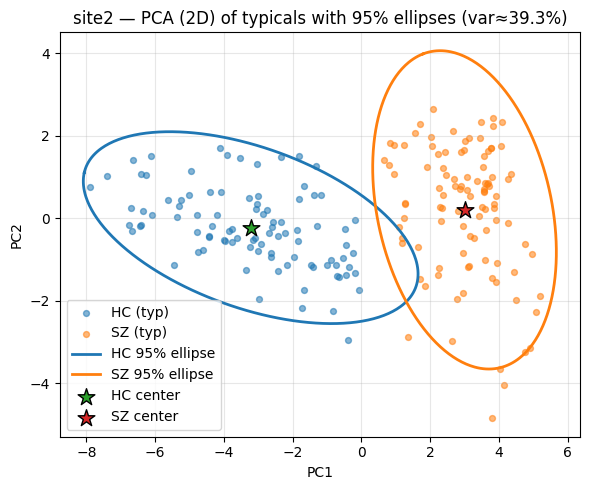

157 50
inside Mask:  157 50
lenght of arr:  50
inside Mask:  157 54
lenght of arr:  54


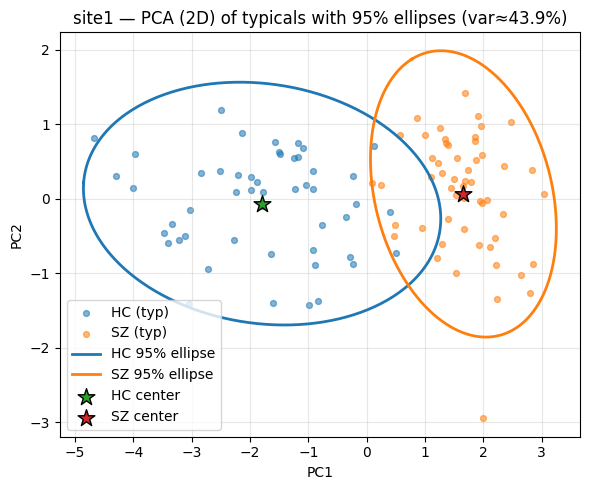

311 93
inside Mask:  311 93
lenght of arr:  93
inside Mask:  311 101
lenght of arr:  101


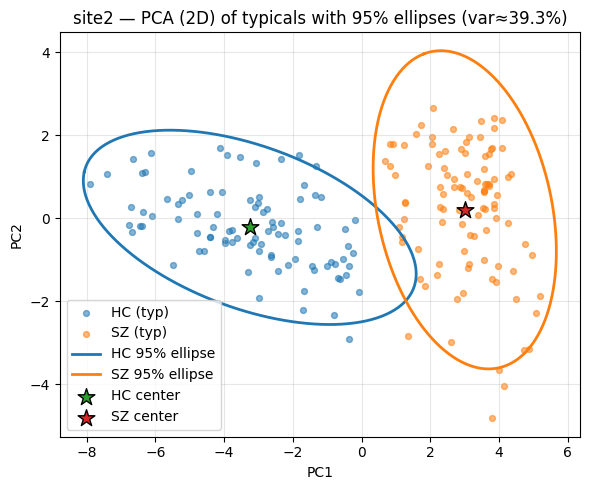

157 50
inside Mask:  157 50
lenght of arr:  50
inside Mask:  157 56
lenght of arr:  56


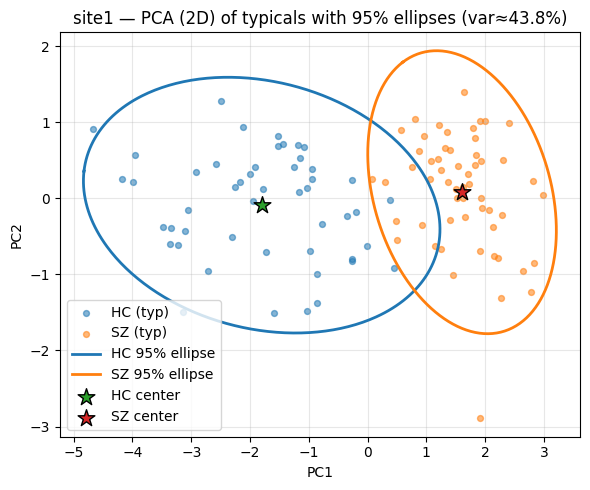

311 95
inside Mask:  311 95
lenght of arr:  95
inside Mask:  311 100
lenght of arr:  100


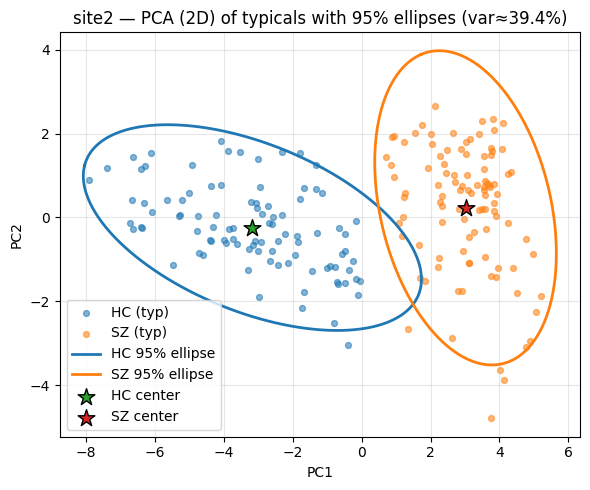

In [11]:
import numpy as np
from scipy.constants import R

try:
    from sklearn.covariance import LedoitWolf
    _HAS_SK = True
except Exception:
    _HAS_SK = False

def _to_mask(n, idx_or_mask):
    print("inside Mask: ", n, len(idx_or_mask))
    arr = np.asarray(idx_or_mask)
    print("lenght of arr: ", len(arr))
    if arr.dtype == bool:
        assert arr.size == n, "Boolean mask length must match n_samples."
        return arr
    mask = np.zeros(n, dtype=bool)
    mask[arr.astype(int)] = True
    return mask

def distances_to_center_typicals(
    X,                    # (N, F) raw features for a site
    y,                    # (N,) labels (unused here; kept for sanity if you need)
    feat_idx,             # (F_sel,) feature indices used to build centers
    center_HC,            # (F_sel,) HC center (mean over typical HCs on feat_idx)
    center_SZ,            # (F_sel,) SZ center (mean over typical SZs on feat_idx)
    typ_idx_HC,           # indices OR boolean mask of typical HC subjects in this site
    typ_idx_SZ,           # indices OR boolean mask of typical SZ subjects in this site
    use_mahalanobis=True  # optional extra diagnostic (not in MATLAB)
):
    """
    Computes distances of *typical* subjects to their own class center
    in the exact subspace the centers were built in (no extra scaling).

    Returns:
      {
        "euclid": {"HC": dE_HC (n_HC,), "SZ": dE_SZ (n_SZ,)},
        "mahal":  {"HC": dM_HC (n_HC,) or None, "SZ": dM_SZ (n_SZ,) or None},
        "summary": { medians/IQRs for quick logging }
      }
    """
    X = np.asarray(X)
    Fsel = np.asarray(feat_idx, dtype=int)
    print(X.shape[0], len(typical_hc_ind))
    mask_HC = _to_mask(X.shape[0], typ_idx_HC)
    mask_SZ = _to_mask(X.shape[0], typ_idx_SZ)

    # Project to the exact feature subset used for centers
    X_HC = X[mask_HC][:, Fsel]
    X_SZ = X[mask_SZ][:, Fsel]

    # --- Euclidean (MATLAB-parity) ---
    dE_HC = np.linalg.norm(X_HC - center_HC, axis=1)
    dE_SZ = np.linalg.norm(X_SZ - center_SZ, axis=1)

    # --- Mahalanobis (optional diagnostic) ---
    dM_HC = dM_SZ = None
    if use_mahalanobis and _HAS_SK:
        def mahal(Xg, Cg):
            # Ledoit–Wolf shrinkage keeps Σ^{-1} stable when F_sel is large
            if Xg.shape[0] < 3:
                return np.linalg.norm(Xg - Cg, axis=1)  # fallback
            lw = LedoitWolf().fit(Xg)  # covariance from the same group/subspace
            P = lw.precision_
            Xm = Xg - Cg
            d2 = np.einsum('ij,jk,ik->i', Xm, P, Xm)
            d2[d2 < 0] = 0
            return np.sqrt(d2)
        dM_HC = mahal(X_HC, center_HC)
        dM_SZ = mahal(X_SZ, center_SZ)

    # Quick summary stats
    def _iqr(x):
        q1, q3 = np.percentile(x, [25, 75])
        return float(np.median(x)), float(q3 - q1)

    summary = {
        "euclid": {
            "HC_median": _iqr(dE_HC)[0], "HC_IQR": _iqr(dE_HC)[1],
            "SZ_median": _iqr(dE_SZ)[0], "SZ_IQR": _iqr(dE_SZ)[1],
        },
        "mahal": None
    }
    if dM_HC is not None and dM_SZ is not None:
        summary["mahal"] = {
            "HC_median": _iqr(dM_HC)[0], "HC_IQR": _iqr(dM_HC)[1],
            "SZ_median": _iqr(dM_SZ)[0], "SZ_IQR": _iqr(dM_SZ)[1],
        }

    return {
        "euclid": {"HC": dE_HC, "SZ": dE_SZ},
        "mahal":  {"HC": dM_HC, "SZ": dM_SZ},
        "summary": summary
    }

for i in ROUNDS:
    for site in SITES:
        center_path = os.path.join(BASE_DIR, f'round_{i}', site, 'centers.npz')
        
        raw_center = np.load(center_path)
        centers = {key: raw_center[key] for key in raw_center.files}
        
        data_path = os.path.join(BASE_DIR, f'round_{i}', site, f'{site}.mat')
        data = load_result_matfile(data_path)[site]
        
        labels = data[:,-1]
        data = data[:, :-1]
                
        selected_features = centers['selected_features']
        typical_sz_ind = centers['typ_sz']
        typical_hc_ind = centers['typ_hc']
        center_hc = centers['center_hc'][0]
        center_sz = centers['center_sz'][0]
        
        # print(data.shape)
        # print(len(labels))
        # print(len(selected_features))
        # print(len(center_hc))
        # print(len(center_sz))
        # print(len(typical_hc_ind))
        # print(len(typical_sz_ind))
        
        # break
        ans = distances_to_center_typicals (
            data, labels,
            centers['selected_features'], centers['center_hc'],
            centers['center_sz'], centers['typ_hc'], centers['typ_sz']
        )

        
        # plot_distance_boxplots(ans, site_name=f"Site {site}")
        # plot_distance_ecdfs(ans, site_name=f"Site {site}")
        
        plot_pca_ellipses_typicals(
            data,
            centers['selected_features'],
            centers['typ_hc'], 
            centers['typ_sz'],
            centers['center_hc'],
            centers['center_sz'],
            site
        )
        
        # print(ans)
        
